In [1]:
try:
    import anastruct, openturns, numba, joblib
except:
    import os
    if os.sys.platform == 'linux' :
        file_path = 'sensitivityEnv.yml'
        os.system('conda env create -f'+file_path)
        # to have the right modules installed
        print('now activate the environment and restart jupyter with other kernel')
    else :
        print('Do it alone')

In [2]:
import NdGaussianProcessSensitivity_MOD as ngps
import NdGaussianProcessConstructor as ngpc
# Classes utilitaires
import numpy                        as np
import openturns                    as ot
import matplotlib.pyplot            as plt
from   importlib                import reload 

# on importe aussi les fonctions à étudier
import RandomBeamGenerationClass    as rbgc

%pylab inline
pylab.rcParams['figure.figsize'] = (13, 5)

trend function args:  ['x']  trend function:  210000 

Please be aware that the number of elements in the argument list has to be the same as the dimension of the process:  1
trend function args:  ['x']  trend function:  10 

Please be aware that the number of elements in the argument list has to be the same as the dimension of the process:  1
Populating the interactive namespace from numpy and matplotlib


In [3]:
# process governing the young modulus for each element      (MPa)
process_E = ngpc.NdGaussianProcessConstructor(dimension=1,
                                              grid_shape=[[0,1000,100],],
                                              covariance_model={'NameModel':'MaternModel',
                                                                'amplitude':3150.,
                                                                'scale':300,
                                                                'nu':13/3},
                                              trend_arguments=['x'],trend_function=210000)
process_E.setName('E_')


# process governing the diameter for each element          (mm)
process_D = ngpc.NdGaussianProcessConstructor(dimension=1,
                                              grid_shape=[[0,1000,100],],
                                              covariance_model={'NameModel':'MaternModel',
                                                                'amplitude':.15,
                                                                'scale':250,
                                                                'nu':7.4/3},
                                              trend_arguments=['x'],trend_function=10)
process_D.setName('D_')


# random variable for the density of the material (kg/m³)
rho         = 7850.
sigma       = 117.5
nameD       = 'Rho'
RV_Rho = ngpc.NormalDistribution(mu = rho, sigma = sigma, name = nameD)


# random variable for the position of the force   (mm) 
middle       = 500
sigma_f      = 7.5
namePos     = 'FP'
RV_Fpos = ngpc.NormalDistribution(mu = middle, sigma = sigma_f, name = namePos)


# random variable for the norm of the force    (N)
muForce       = 100
# we go from sigma = 15 to sigma = 1.5, as the influence is too important
sigma_Fnor    = 1.5
nameNor       = 'FN'
RV_Fnorm = ngpc.NormalDistribution(mu = muForce, sigma = sigma_Fnor, name = nameNor)

trend function args:  ['x']  trend function:  210000 

Please be aware that the number of elements in the argument list has to be the same as the dimension of the process:  1
trend function args:  ['x']  trend function:  10 

Please be aware that the number of elements in the argument list has to be the same as the dimension of the process:  1


In [4]:
from importlib import reload
reload(ngps)
outputVariables = {'out1' :
                   {
                         'name'     : 'VonMisesStress',
                         'position' : 0,
                         'shape'    : (102,)  
                    },
                   'out2' :
                   {
                        'name'      : 'maxDeflection',
                        'position'  : 1,
                        'shape'     : (1,)
                   }
                  }
#Pour utiliser notre fonction, un wrapper a été spécialement écrit pour faciliter l'accès aux fonctions mais
#ce choix est entièrement dépendant de la manière dont a été définie la fonction sur laquelle vous travaillez.
functionWrapper = rbgc.sampleAndSoloFunctionWrapper(process_E, process_D, RV_Rho, RV_Fpos, RV_Fnorm)


In [5]:
inputVarList = [process_E, process_D, RV_Rho, RV_Fpos, RV_Fnorm]
# We also the need the two functions of the model (one for samples, the other for single evaluations)
# In our case, as our model is defined as a class, we have to first create the model, 
# but it also could just be just two functions taking as an input the fields and RVs
soloFunction   = functionWrapper.randomBeamFunctionSolo
sampleFunction = functionWrapper.randomBeamFunctionSample
##
size           = 10000 ## Number of samples for our sobol indicies experiment (kept low here to make things faster)
##
reload(ngps)
##
processSensitivityAnalysis = ngps.NdGaussianProcessSensitivityAnalysis(inputVarList, 
                                                                       outputVariables,
                                                                       sampleFunction,
                                                                       soloFunction,
                                                                       size)

Input Variables are (without Karhunen Loeve Decomposition) :
 ['E_', 'D_', 'Rho', 'FP', 'FN'] 

Output Variables are :
 ['VonMisesStress', 'maxDeflection'] 

trend function args:  ['x']  trend function:  210000 

Please be aware that the number of elements in the argument list has to be the same as the dimension of the process:  1
trend function args:  ['x']  trend function:  10 

Please be aware that the number of elements in the argument list has to be the same as the dimension of the process:  1


In [6]:
processSensitivityAnalysis.prepareSobolIndicesExperiment()

Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)
number of samples for sobol experiment =  70000 

input design is:  [[ 8.48665236e+01  6.90071063e-01  3.83240516e+01 ...  7.87401141e+03
   5.05421939e+02  9.75840749e+01]
 [ 8.78200369e+01  6.07561060e-01  3.85704894e+01 ...  7.95315586e+03
   4.97851721e+02  1.01198313e+02]
 [ 8.84702893e+01  1.36249483e+00  3.73533402e+01 ...  7.73771012e+03
   5.00051116e+02  9.86893492e+01]
 ...
 [ 8.61853898e+01 -1.42292882e+00  3.77437754e+01 ...  7.82780218e+03
   4.96401442e+02  1.00947767e+02]
 [ 8.77319356e+01 -1.36724434e+00  3.87982374e+01 ...  7.78201210e+03
   5.06232954e+02  9.78877494e+01]
 [ 8.62791847e+01  2.49802721e-01  3.80560573e+01 ...  7.87459873e+03
   4.98005572e+02  9.94324296e+01]]


In [7]:
processSensitivityAnalysis.getOutputDesignAndPostprocess()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

[Parallel(n_jobs=-1)]: Done 9232 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 9369 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 9506 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 9645 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 9925 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 10066 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 10209 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 10352 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 10497 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 10642 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 10789 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 10936 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 11085 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 11234 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 11385 tasks      |

[Parallel(n_jobs=-1)]: Done 35097 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 35362 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 35629 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 35896 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 36165 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 36434 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 36705 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 36976 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 37249 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 37522 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 37797 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 38072 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 38349 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 38626 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 38905 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done 39184 tasks 

shape deflection:  (70000, 103)  should be [N,10X] something
deflection std deviation  nan
timed  2491.524522066  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (70000, 102)
Element  2  has shape  (70000,)
Final shape matrix:  (70000, 103)
Columns where nan :  [ 1269  2065  6501 17637 18983 19499 21074 23157 26501 30711 31074 31269
 33157 36501 41269 42065 46501 58983 61269 62065 66501] 

There were  21  errors (numpy.nan) while processing, trying to regenerate missing outputs 

index to change:  [ 1269 11269 21269 31269 41269 51269 61269]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  0.687705192040281
timed  0.311278582  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 2065 12065 22065 32065 42065 52065 62065]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  0.24755899564639441
timed  0.286616087  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 6501 16501 26501 36501 46501 56501 66501]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  0.2936411019027184
timed  0.303256989  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 7637 17637 27637 37637 47637 57637 67637]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1896s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  0.4442228923028508
timed  0.284992218  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 8983 18983 28983 38983 48983 58983 68983]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.4s finished


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  0.7345280478694428
timed  0.364397049  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 9499 19499 29499 39499 49499 59499 69499]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  0.5537907824639052
timed  0.300673723  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 1074 11074 21074 31074 41074 51074 61074]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  1.2715027628972138
timed  0.288777113  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 3157 13157 23157 33157 43157 53157 63157]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  0.8018735894386347
timed  0.33791852  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 6501 16501 26501 36501 46501 56501 66501]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1880s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  0.5075684152691745
timed  0.30233407  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [  711 10711 20711 30711 40711 50711 60711]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1855s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  0.6819241925870402
timed  0.283357143  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 1074 11074 21074 31074 41074 51074 61074]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1999s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  0.9341030299790577
timed  0.294952631  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 1269 11269 21269 31269 41269 51269 61269]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  0.4312293086032127
timed  0.328228712  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 3157 13157 23157 33157 43157 53157 63157]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  0.3551732498678581
timed  0.287682533  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 6501 16501 26501 36501 46501 56501 66501]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1924s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  0.2791415002361885
timed  0.291051149  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 1269 11269 21269 31269 41269 51269 61269]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  0.594157484826323
timed  0.33878541  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 2065 12065 22065 32065 42065 52065 62065]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1995s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  1.2916013529115347
timed  0.284061909  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 6501 16501 26501 36501 46501 56501 66501]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  0.26789551487702956
timed  0.292675495  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 8983 18983 28983 38983 48983 58983 68983]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  0.5488047694890013
timed  0.276690006  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 1269 11269 21269 31269 41269 51269 61269]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  0.45411778795077445
timed  0.286396027  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 2065 12065 22065 32065 42065 52065 62065]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  1.4409677388761906
timed  0.279383421  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 6501 16501 26501 36501 46501 56501 66501]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1963s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s finished


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  0.6373649869333786
timed  0.312259674  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
 - Post replacement assertion passed - 

Transforming matrix of shape  (70000, 103)
Into list of Ndarrays according to output definition
Dimension output  0  is  102
Intermediary shape is : (70000, 102)
new shape is:  [70000, 102]
Output element  0  has shape  (70000, 102)
Dimension output  1  is  1
Intermediary shape is : (70000, 1)
new shape is:  [70000, 1]
Output element  1  has shape  (70000,)


In [9]:
import NdGaussianProcessSensitivityIndices as ngpsi
reload(ngpsi)
processSensitivityAnalysis.outputDesignList

[array([[ 1.45571006,  5.1332028 ,  9.85421913, ..., 14.26174709,
          9.62451301,  5.01870349],
        [ 1.47372439,  5.13686167,  9.86622782, ..., 15.50903072,
         10.51802909,  5.50492538],
        [ 1.52121361,  5.47105325, 10.5654129 , ..., 14.5148092 ,
          9.81923271,  5.13012565],
        ...,
        [ 1.52281201,  5.3800783 , 10.32861633, ..., 14.45971736,
          9.80328866,  5.13442073],
        [ 1.4134061 ,  4.95456457,  9.54133936, ..., 14.99629837,
         10.12160977,  5.27460464],
        [ 1.47997222,  5.2268161 , 10.07942607, ..., 14.80881292,
         10.05535253,  5.27080633]]),
 array([5.01870349, 5.50492538, 5.13012565, ..., 5.13442073, 5.27460464,
        5.27080633])]

In [10]:
output = processSensitivityAnalysis.outputDesignList
output1 = output[0]
output2 = output[1]
S, Stot = ngpsi.NdGaussianProcessSensitivityIndicesBase.getSobolIndices(output1,10000)
S2, Stot2 = ngpsi.NdGaussianProcessSensitivityIndicesBase.getSobolIndices(output2,10000)

There are 5 indices to get in (102,) dimensions with 102 elements
There are 5 indices to get in 1 dimensions with 1 elements


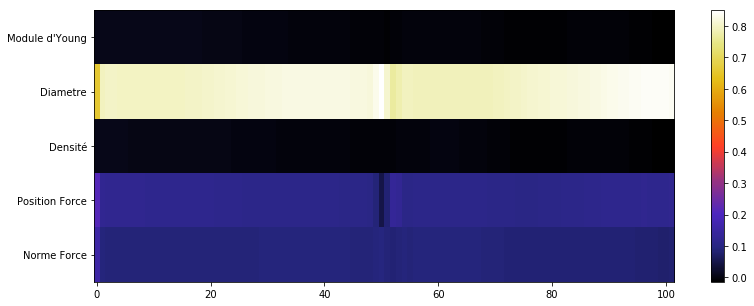

In [11]:
#composedDist = processSensitivityAnalysis.wrappedFunction.KLComposedDistribution
plt.yticks([0,1,2,3,4],["Module d'Young",'Diametre','Densité','Position Force','Norme Force'])
x=plt.imshow(S, cmap='CMRmap',aspect='auto')
plt.colorbar()

In [12]:
S[...,0:5]
S2

array([-0.01418522,  0.83809877, -0.01386103,  0.12272222,  0.08087469])

In [15]:
sob = list(S2)
Sobol=list()
[Sobol.append(round(x,3)) for x in sob]

[None, None, None, None, None]

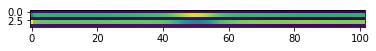

In [36]:
im = plt.imshow(S)

In [37]:
plt.show(im)

In [14]:
print(processSensitivityAnalysis.wrappedFunction.inputVarNames)
print(processSensitivityAnalysis.wrappedFunction.inputVarNamesKL)
print(processSensitivityAnalysis.wrappedFunction._inputVarOrdering)

['E_', 'D_', 'Rho', 'FP', 'FN']
['E_xi_0', 'E_xi_1', 'E_xi_2', 'E_xi_3', 'E_xi_4', 'E_xi_5', 'E_xi_6', 'E_xi_7', 'D_xi_0', 'D_xi_1', 'D_xi_2', 'D_xi_3', 'D_xi_4', 'D_xi_5', 'D_xi_6', 'D_xi_7', 'D_xi_8', 'D_xi_9', 'D_xi_10', 'D_xi_11', 'D_xi_12', 'Rho', 'FP', 'FN']
['var0', 'var1', 'var2', 'var3', 'var4']


In [12]:
import customWraps as cw

In [13]:
@cw.timing
def getLHSExperiment(distribution, size, alwaysShuffle, randomShift):
    return ot.LHSExperiment(distribution, size, alwaysShuffle, randomShift).generate()

In [14]:
exp = getLHSExperiment(composedDist, 2000, True, True)

timed  0.040719986  s for function " getLHSExperiment "


In [15]:
print('That works really fast!')
exp

That works really fast!


class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=2000 dimension=24 description=[X0,X1,X2,...,X21,X22,X23] data=[[55.7903,-0.190982,23.284,...,8005.52,484.736,101.649],[55.3335,1.37126,24.2084,...,7653.51,481.986,97.7207],[54.2023,0.871355,23.8598,...,7814.16,407.555,99.9938],...,[54.8515,-0.523946,24.2193,...,8217.19,477.841,99.5037],[54.4046,-0.329352,25.9664,...,7412.34,507.69,98.9423],[54.3466,-0.570135,24.4115,...,7878.01,402.964,99.9011]]

In [55]:
import NdGaussianProcessExperimentGeneration as ngpeg
reload(ngpeg)

<module 'NdGaussianProcessExperimentGeneration' from '/home/motherloadubu/Documents/project_PHIMECA/stochastic_process_analysis/NdGaussianProcessExperimentGeneration.py'>

In [56]:
test0 = ngpeg.NdGaussianProcessExperiment(processSensitivityAnalysis.sampleSize,
                                         processSensitivityAnalysis.wrappedFunction)

Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS


In [57]:
test0.generate()

array([[ 5.50346146e+01,  9.81992100e-02,  2.47360736e+01, ...,
         7.45248899e+03,  6.01817823e+02,  1.01293963e+02],
       [ 5.37555756e+01,  1.29455188e-01,  2.28109014e+01, ...,
         7.95669043e+03,  4.37887664e+02,  9.96609256e+01],
       [ 5.53507742e+01, -1.25225486e+00,  2.43850209e+01, ...,
         7.96235937e+03,  4.37713257e+02,  1.00149113e+02],
       ...,
       [ 5.60095120e+01,  7.35625214e-01,  2.33273992e+01, ...,
         8.07962019e+03,  5.26993032e+02,  1.00278874e+02],
       [ 5.65213904e+01,  3.75193848e-01,  2.45633504e+01, ...,
         7.82180335e+03,  5.20321230e+02,  9.79694576e+01],
       [ 5.47746640e+01,  1.08818884e+00,  2.43071075e+01, ...,
         7.95333093e+03,  5.59042152e+02,  9.89984624e+01]])

In [49]:
test0.getDataFieldAndRV()

In [50]:
test0.getExperiment()

In [22]:
test = ngpeg.NdGaussianProcessExperiment()

Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS


In [23]:
test.setSampleSize(100)

In [24]:
test.setOTPyFunctionWrapper(processSensitivityAnalysis.wrappedFunction)

In [25]:
test.setGenType(1)
test.generateSample()

In [26]:
test.setGenType(2)
test.generateSample()

In [27]:
test.setGenType(3)
test.generateSample(sequence='Halton')

In [28]:
test.setGenType(4)
arr=test.generateSample()

undefined parameter 'SpaceFilling', setting to default 'SpaceFillingC2'
undefined parameter 'TemperatureProfile', setting default GeometricProfile


In [29]:
print(test.inputVarNames)
print(test.inputVarNamesKL)
test.getDataFieldAndRV()

['E_', 'D_', 'Rho', 'FP', 'FN']
['E_xi_0', 'E_xi_1', 'E_xi_2', 'E_xi_3', 'E_xi_4', 'E_xi_5', 'E_xi_6', 'E_xi_7', 'D_xi_0', 'D_xi_1', 'D_xi_2', 'D_xi_3', 'D_xi_4', 'D_xi_5', 'D_xi_6', 'D_xi_7', 'D_xi_8', 'D_xi_9', 'D_xi_10', 'D_xi_11', 'D_xi_12', 'Rho', 'FP', 'FN']


In [30]:
test.dataMixSamples

[8, 13, 1, 1, 1]

In [31]:
test.sample_A.shape

(100, 24)

In [32]:
test.getExperiment()

In [33]:
test.experimentSample.shape

(700, 24)

In [34]:
np.unique(np.argwhere(test.experimentSample[100:200,...]==test.sample_B)[...,1])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [35]:
np.unique(np.argwhere(test.experimentSample[200:300,...]==test.sample_B)[...,1])

array([0, 1, 2, 3, 4, 5, 6, 7])

In [36]:
np.unique(np.argwhere(test.experimentSample[300:400,...]==test.sample_B)[...,1])

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [37]:
np.unique(np.argwhere(test.experimentSample[400:500,...]==test.sample_B)[...,1])

array([21])

In [38]:
np.unique(np.argwhere(test.experimentSample[500:600,...]==test.sample_B)[...,1])

array([22])

In [39]:
np.unique(np.argwhere(test.experimentSample[600:700,...]==test.sample_B)[...,1])

array([23])

Everything works alright, we get our samples as expected.